<a href="https://www.kaggle.com/code/guilhermeparcerao/mafaulda-tinyml-training-for-fault-detection?scriptVersionId=198295664" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# MAFAULDA TinyML Training for Fault Detection

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.fft import rfft, rfftfreq
from scipy.integrate import cumtrapz
import tensorflow as tf
from os.path import join
from os import walk
from gc import collect
from warnings import filterwarnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
filterwarnings("ignore", category=InterpolationWarning)

2024-09-25 23:02:10.302709: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 23:02:10.302843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 23:02:10.456776: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Database load and creation

Legend according to [MAFAULDA docs](https://www02.smt.ufrj.br/~offshore/mfs/page_01.html):

* Column 1: tachometer signal that allows to estimate rotation frequency;
* Columns 2 to 4: underhang bearing accelerometer (axial, radiale tangential direction);
* Columns 5 to 7: overhang bearing accelerometer (axial, radiale tangential direction);
* Column 8: microphone.

Custom classification legend:

* 0: normal;
* 1: horizontal misalignment;
* 2: vertical misalignment;
* 3: imbalance;

In [2]:
df_normal = pd.DataFrame()
folder = '/kaggle/input/mafaulda-full/mafaulda/normal'
total_files = sum([len(files) for _, _, files in walk(folder)])
half_files = np.ceil(total_files * 0.25)
file_count = 0
index_df = [0, 1, 2, 3, 4, 5, 6, 7]

for dirpath, dirnames, filenames in walk(folder):
    for i, file in enumerate(filenames):
        
        if file_count >= half_files:
            break

        df_chunks = pd.read_csv(join(dirpath, file), chunksize=100000, names=['rot_freq', 'uhang_x', 'uhang_y', 'uhang_z', 'ohang_x', 'ohang_y', 'ohang_z', 'microphone'])
        
        for chunk in df_chunks:
            df_normal = pd.concat([chunk, df_normal])
        
        file_count += 1
        
        for i in range(len(index_df)):
            index_df[i] += 1
        
df_normal['class'] = 0
df_normal.reset_index(inplace=True, drop=True)
df_normal

,rot_freq,uhang_x,uhang_y,uhang_z,ohang_x,ohang_y,ohang_z,microphone,class
0,4.45120,0.715890,-0.284200,-0.156640,0.15180,0.043086,-0.132050,0.250240,0
1,4.43510,-0.611990,-0.036589,-0.177420,0.14875,0.042284,-0.053911,-0.153740,0
2,4.43840,0.964500,0.084935,-0.118130,0.19624,0.048849,0.131020,0.099203,0
3,4.44640,-0.725030,-0.217920,-0.138780,0.12676,0.047700,0.153350,0.030619,0
4,4.42500,1.027400,0.379270,0.004222,0.18157,0.052898,0.326180,-0.079583,0
...,...,...,...,...,...,...,...,...,...
3249995,-0.76078,-0.546360,-0.863020,-0.017809,0.39801,-0.013208,0.412460,0.563960,0
3249996,-0.65087,-0.847700,-0.290520,0.011313,0.40664,-0.011739,0.355020,-0.231140,0
3249997,-0.72317,-0.091599,-0.489430,-0.121290,0.36801,-0.008408,0.294860,0.325030,0
3249998,-0.70948,-1.160600,-0.542830,-0.296920,0.22481,-0.011758,0.116480,0.127020,0


In [3]:
df_hmis = pd.DataFrame()
folder = '/kaggle/input/mafaulda-full/mafaulda/horizontal-misalignment/0.5mm'
total_files = sum([len(files) for _, _, files in walk(folder)])
half_files = np.ceil(total_files * 0.25)
file_count = 0
index_df = [0, 1, 2, 3, 4, 5, 6, 7]

for dirpath, dirnames, filenames in walk(folder):
    for i, file in enumerate(filenames):
        
        if file_count >= half_files:
            break

        df_chunks = pd.read_csv(join(dirpath, file), chunksize=100000, names=['rot_freq', 'uhang_x', 'uhang_y', 'uhang_z', 'ohang_x', 'ohang_y', 'ohang_z', 'microphone'])
        
        for chunk in df_chunks:
            df_hmis = pd.concat([chunk, df_normal])
        
        file_count += 1
        
        for i in range(len(index_df)):
            index_df[i] += 1
        
df_hmis['class'] = 1
df_hmis.reset_index(inplace=True, drop=True)
df_hmis

,rot_freq,uhang_x,uhang_y,uhang_z,ohang_x,ohang_y,ohang_z,microphone,class
0,-0.72336,0.025037,0.408920,0.984850,-2.28670,0.016242,-0.70277,-0.019858,1
1,-0.70719,0.227100,-0.074799,0.887990,-2.44420,0.016376,-0.67076,0.042788,1
2,-0.71950,0.495530,0.596450,0.758660,-2.46360,0.026754,-0.37686,-0.154130,1
3,-0.71358,0.223710,-0.262470,0.359920,-2.72180,0.024334,-0.38949,0.139290,1
4,-0.71142,0.567930,0.721270,0.128770,-2.51380,0.025836,-0.29535,-0.228650,1
...,...,...,...,...,...,...,...,...,...
3299995,-0.76078,-0.546360,-0.863020,-0.017809,0.39801,-0.013208,0.41246,0.563960,1
3299996,-0.65087,-0.847700,-0.290520,0.011313,0.40664,-0.011739,0.35502,-0.231140,1
3299997,-0.72317,-0.091599,-0.489430,-0.121290,0.36801,-0.008408,0.29486,0.325030,1
3299998,-0.70948,-1.160600,-0.542830,-0.296920,0.22481,-0.011758,0.11648,0.127020,1


In [4]:
df_vmis = pd.DataFrame()
folder = '/kaggle/input/mafaulda-full/mafaulda/vertical-misalignment/0.51mm'
total_files = sum([len(files) for _, _, files in walk(folder)])
half_files = np.ceil(total_files * 0.25)
file_count = 0
index_df = [0, 1, 2, 3, 4, 5, 6, 7]

for dirpath, dirnames, filenames in walk(folder):
    for i, file in enumerate(filenames):
        
        if file_count >= half_files:
            break

        df_chunks = pd.read_csv(join(dirpath, file), chunksize=100000, names=['rot_freq', 'uhang_x', 'uhang_y', 'uhang_z', 'ohang_x', 'ohang_y', 'ohang_z', 'microphone'])
        
        for chunk in df_chunks:
            df_vmis = pd.concat([chunk, df_normal])
        
        file_count += 1
        
        for i in range(len(index_df)):
            index_df[i] += 1
        
df_vmis['class'] = 2
df_vmis.reset_index(inplace=True, drop=True)
df_vmis

,rot_freq,uhang_x,uhang_y,uhang_z,ohang_x,ohang_y,ohang_z,microphone,class
0,-0.26741,1.211400,0.427410,0.061238,-0.19592,-0.041349,-0.21933,0.001510,2
1,-0.48245,-0.019217,-0.294830,0.055033,-0.20795,-0.043865,-0.25106,-0.050378,2
2,-0.24893,1.019200,0.572310,0.015552,-0.20656,-0.045597,-0.21984,-0.064932,2
3,-0.51596,0.315670,-0.254680,-0.146800,-0.21867,-0.050962,-0.28568,-0.015210,2
4,-0.28917,0.531090,0.451630,-0.203780,-0.21712,-0.053472,-0.28891,-0.119280,2
...,...,...,...,...,...,...,...,...,...
3299995,-0.76078,-0.546360,-0.863020,-0.017809,0.39801,-0.013208,0.41246,0.563960,2
3299996,-0.65087,-0.847700,-0.290520,0.011313,0.40664,-0.011739,0.35502,-0.231140,2
3299997,-0.72317,-0.091599,-0.489430,-0.121290,0.36801,-0.008408,0.29486,0.325030,2
3299998,-0.70948,-1.160600,-0.542830,-0.296920,0.22481,-0.011758,0.11648,0.127020,2


In [5]:
df_imb = pd.DataFrame()
folder = '/kaggle/input/mafaulda-full/mafaulda/imbalance/10g'
total_files = sum([len(files) for _, _, files in walk(folder)])
half_files = np.ceil(total_files * 0.25)
file_count = 0
index_df = [0, 1, 2, 3, 4, 5, 6, 7]

for dirpath, dirnames, filenames in walk(folder):
    for i, file in enumerate(filenames):
        
        if file_count >= half_files:
            break

        df_chunks = pd.read_csv(join(dirpath, file), chunksize=100000, names=['rot_freq', 'uhang_x', 'uhang_y', 'uhang_z', 'ohang_x', 'ohang_y', 'ohang_z', 'microphone'])
        
        for chunk in df_chunks:
            df_imb = pd.concat([chunk, df_normal])
        
        file_count += 1
        
        for i in range(len(index_df)):
            index_df[i] += 1
        
df_imb['class'] = 3
df_imb.reset_index(inplace=True, drop=True)
df_imb

,rot_freq,uhang_x,uhang_y,uhang_z,ohang_x,ohang_y,ohang_z,microphone,class
0,-0.67757,-0.704340,-0.508310,-0.011726,-0.006906,0.003182,0.25950,-0.110830,3
1,-0.64563,1.002800,-0.097861,-0.001289,-0.002956,0.006031,0.26768,0.103170,3
2,-0.69777,-0.647460,-0.522130,-0.111690,-0.015261,-0.000104,0.22027,0.105750,3
3,-0.64700,0.858420,0.128700,0.001961,-0.008408,0.000654,0.40810,-0.101970,3
4,-0.66406,-0.403070,-0.559650,-0.098031,-0.014979,-0.002433,0.26694,0.252020,3
...,...,...,...,...,...,...,...,...,...
3299995,-0.76078,-0.546360,-0.863020,-0.017809,0.398010,-0.013208,0.41246,0.563960,3
3299996,-0.65087,-0.847700,-0.290520,0.011313,0.406640,-0.011739,0.35502,-0.231140,3
3299997,-0.72317,-0.091599,-0.489430,-0.121290,0.368010,-0.008408,0.29486,0.325030,3
3299998,-0.70948,-1.160600,-0.542830,-0.296920,0.224810,-0.011758,0.11648,0.127020,3


In [6]:
df_raw_general = pd.concat([df_normal, df_hmis, df_vmis, df_imb])
df_raw_general.reset_index(inplace=True, drop=True)
df_raw_general

,rot_freq,uhang_x,uhang_y,uhang_z,ohang_x,ohang_y,ohang_z,microphone,class
0,4.45120,0.715890,-0.284200,-0.156640,0.15180,0.043086,-0.132050,0.250240,0
1,4.43510,-0.611990,-0.036589,-0.177420,0.14875,0.042284,-0.053911,-0.153740,0
2,4.43840,0.964500,0.084935,-0.118130,0.19624,0.048849,0.131020,0.099203,0
3,4.44640,-0.725030,-0.217920,-0.138780,0.12676,0.047700,0.153350,0.030619,0
4,4.42500,1.027400,0.379270,0.004222,0.18157,0.052898,0.326180,-0.079583,0
...,...,...,...,...,...,...,...,...,...
13149995,-0.76078,-0.546360,-0.863020,-0.017809,0.39801,-0.013208,0.412460,0.563960,3
13149996,-0.65087,-0.847700,-0.290520,0.011313,0.40664,-0.011739,0.355020,-0.231140,3
13149997,-0.72317,-0.091599,-0.489430,-0.121290,0.36801,-0.008408,0.294860,0.325030,3
13149998,-0.70948,-1.160600,-0.542830,-0.296920,0.22481,-0.011758,0.116480,0.127020,3


## Data validation and preparation

Result for isna test: False
Result for duplicated test: False


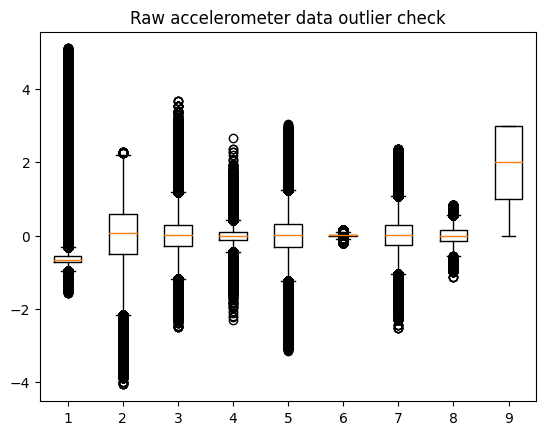

In [7]:
raw_general_isna = df_raw_general.isna().values.any()
raw_general_duplicated = df_raw_general.duplicated().values.any()
print(f"Result for isna test: {raw_general_isna}")
print(f"Result for duplicated test: {raw_general_duplicated}")
plt.title("Raw accelerometer data outlier check")
plt.boxplot(df_raw_general)
plt.show()

In [8]:
def test_stationarity(series):
    adf_result = adfuller(series)
    kpss_result = kpss(series, regression='c', nlags='auto')

    return {
        "adf_statistic": adf_result[0],
        "adf_pvalue": adf_result[1],
        "kpss_statistic": kpss_result[0],
        "kpss_pvalue": kpss_result[1],
    }

def plot_rolling_stats(final_df, axis):
    plt.figure(figsize=(10, 6))
    rolling_mean = final_df[axis].rolling(window=50).mean()
    rolling_variance = final_df[axis].rolling(window=50).var()
    plt.plot(final_df[axis], label=f'{axis} axis signal')
    plt.plot(rolling_mean, label='Rolling Mean', color='red')
    plt.plot(rolling_variance, label='Rolling Variance', color='green')
    plt.title(f'Rolling Mean & Variance - {axis} Axis (Final Result)')
    plt.legend()
    plt.show()

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



--- Final Stationarity Results ---
--- ohang_x axis ---
ADF Statistic: -16.916076058371726
ADF p-value: 1.472746676557992e-11
KPSS Statistic: 1.9297694920455821
KPSS p-value: 0.015052149774944347
ADF Test indicates stationarity
KPSS Test indicates non-stationarity

--- ohang_y axis ---
ADF Statistic: -23.822872370807236
ADF p-value: 8.359404946737394e-31
KPSS Statistic: 0.8894485796721796
KPSS p-value: 0.06603525999627086
ADF Test indicates stationarity
KPSS Test indicates stationarity

--- ohang_z axis ---
ADF Statistic: -12.487531606124126
ADF p-value: 1.3812890096856058e-11
KPSS Statistic: 6.817849765940426
KPSS p-value: 0.010125150937817746
ADF Test indicates stationarity
KPSS Test indicates non-stationarity

--- uhang_x axis ---
ADF Statistic: -29.26149351134327
ADF p-value: 0.0
KPSS Statistic: 0.014914633070386478
KPSS p-value: 0.10000000000000019
ADF Test indicates stationarity
KPSS Test indicates stationarity

--- uhang_y axis ---
ADF Statistic: -29.542813469197775
ADF p-value

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


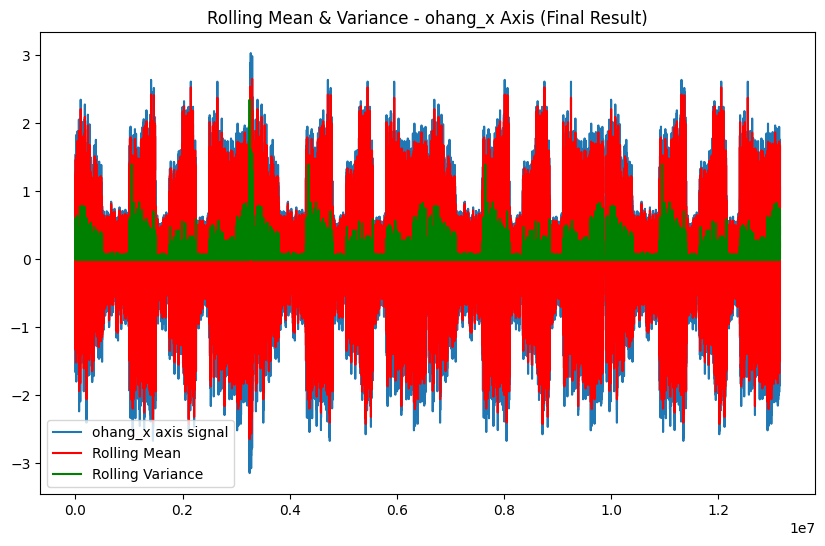

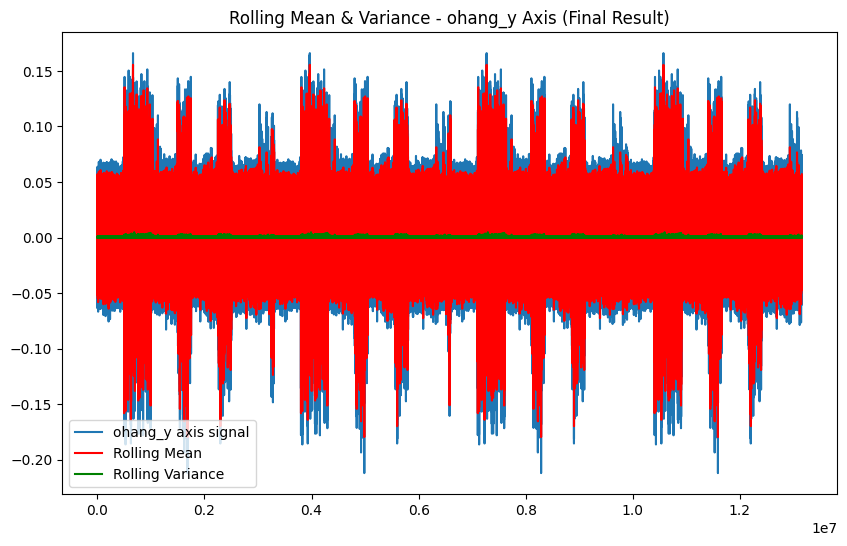

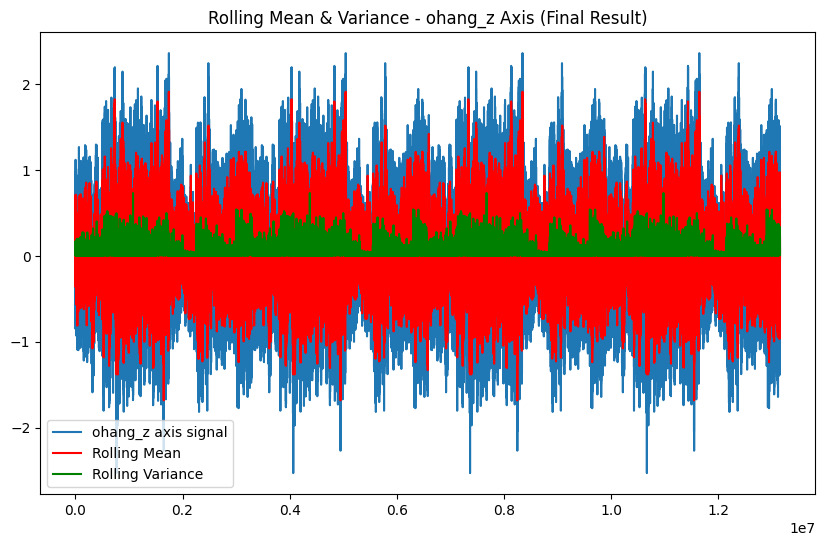

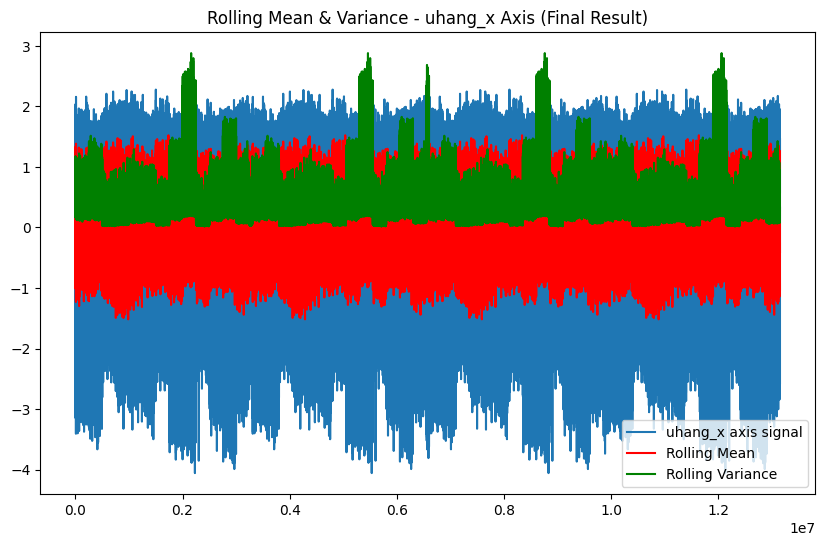

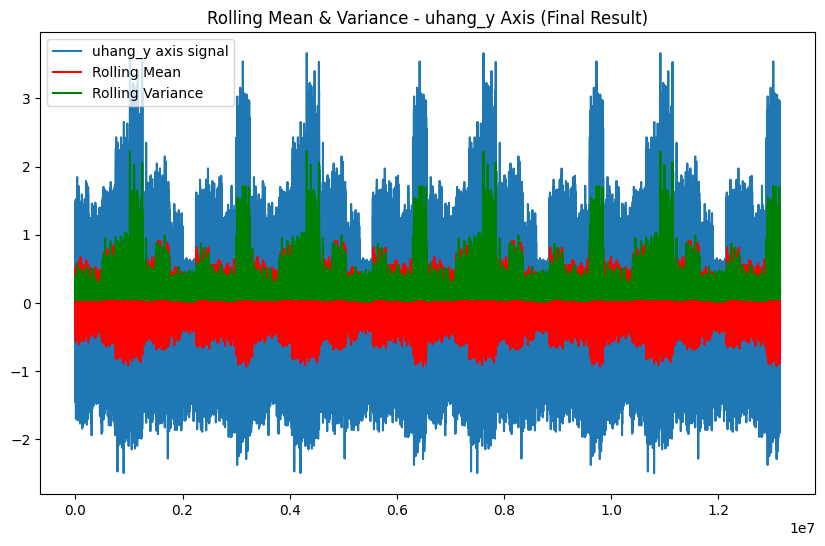

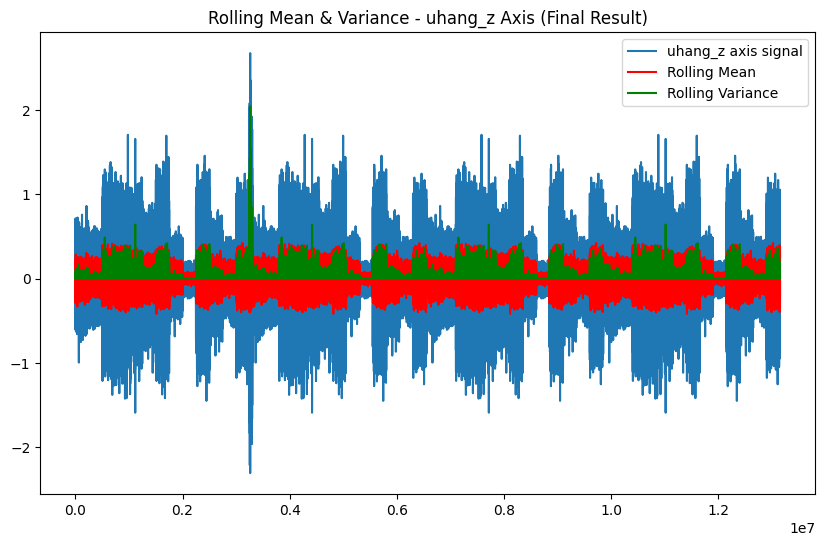

In [9]:
chunk_size = 100000
chunks = np.array_split(df_raw_general, np.ceil(len(df_raw_general) / chunk_size))
prev_chunk_end = None
final_df = pd.DataFrame()
stationarity_results = {axis: {"adf_statistic": 0, "adf_pvalue": 0, "kpss_statistic": 0, "kpss_pvalue": 0} for axis in ['ohang_x', 'ohang_y', 'ohang_z', 'uhang_x', 'uhang_y', 'uhang_z']}
n_chunks = len(chunks)

for i, chunk in enumerate(chunks):

    if prev_chunk_end is not None:
        chunk = pd.concat([prev_chunk_end, chunk], ignore_index=True)

    for axis in ['ohang_x', 'ohang_y', 'ohang_z', 'uhang_x', 'uhang_y', 'uhang_z']:
        test_results = test_stationarity(chunk[axis])
        stationarity_results[axis]["adf_statistic"] += test_results["adf_statistic"] / n_chunks
        stationarity_results[axis]["adf_pvalue"] += test_results["adf_pvalue"] / n_chunks
        stationarity_results[axis]["kpss_statistic"] += test_results["kpss_statistic"] / n_chunks
        stationarity_results[axis]["kpss_pvalue"] += test_results["kpss_pvalue"] / n_chunks

    prev_chunk_end = chunk.iloc[-50:]
    final_df = pd.concat([final_df, chunk], ignore_index=True)
    del chunk
    collect()

print("\n--- Final Stationarity Results ---")

for axis, results in stationarity_results.items():
    print(f"--- {axis} axis ---")
    print(f"ADF Statistic: {results['adf_statistic']}")
    print(f"ADF p-value: {results['adf_pvalue']}")
    print(f"KPSS Statistic: {results['kpss_statistic']}")
    print(f"KPSS p-value: {results['kpss_pvalue']}")
    print("ADF Test indicates stationarity" if results['adf_pvalue'] < 0.05 else "ADF Test indicates non-stationarity")
    print("KPSS Test indicates stationarity" if results['kpss_pvalue'] > 0.05 else "KPSS Test indicates non-stationarity")
    print()

for axis in ['ohang_x', 'ohang_y', 'ohang_z', 'uhang_x', 'uhang_y', 'uhang_z']:
    plot_rolling_stats(final_df, axis)

In [10]:
SAMPLE_RATE = 51200 # from MAFAULDA documentation

In [11]:
def accel_fft_spectrum(x_accel, y_accel, z_accel, n_samples):
    yf1 = rfft(x_accel - np.mean(x_accel))
    yf2 = rfft(y_accel - np.mean(y_accel))
    yf3 = rfft(z_accel - np.mean(z_accel))
    xf = rfftfreq(n_samples, 1 / SAMPLE_RATE)
    
    plt.plot(xf, np.abs(yf1), color='blue')
    plt.plot(xf, np.abs(yf2), color='green')
    plt.plot(xf, np.abs(yf3), color='yellow')
    
def vel_fft_spectrum(freq): 
    rad_per_sec = freq * (2 * (np.pi / 60))
    ang_vel = cumtrapz(y=rad_per_sec, dx=1 / SAMPLE_RATE)
    
    yf = rfft(ang_vel - np.mean(ang_vel))
    xf = rfftfreq(len(ang_vel), 1 / SAMPLE_RATE)
    
    plt.plot(xf, np.abs(yf), color='blue')

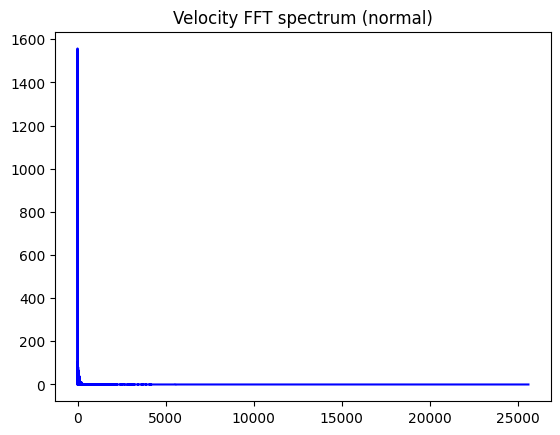

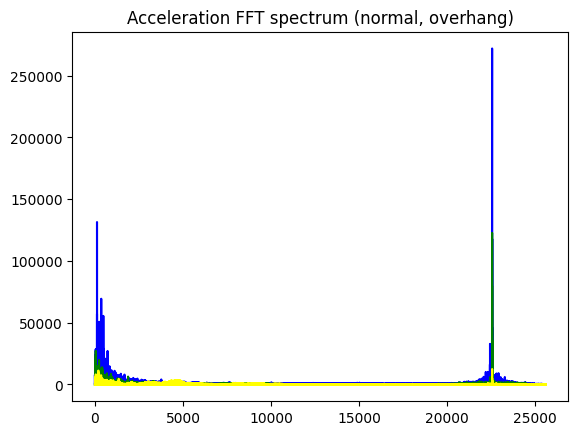

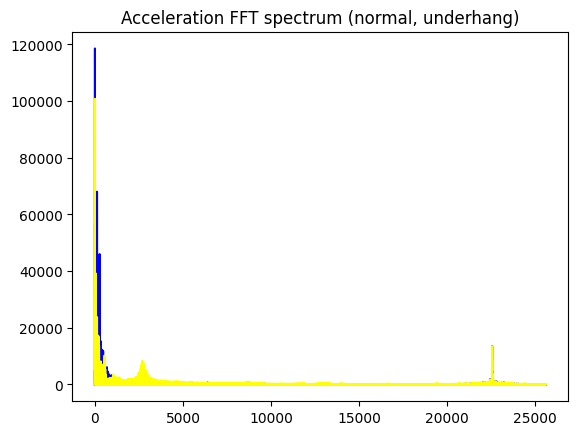

In [12]:
vel_fft_spectrum(df_normal.iloc[:,0].values)
plt.title("Velocity FFT spectrum (normal)")
plt.show()

accel_fft_spectrum(df_normal.iloc[:,1].values, df_normal.iloc[:,2].values, df_normal.iloc[:,3].values, df_normal.iloc[:,1].shape[0])
plt.title("Acceleration FFT spectrum (normal, overhang)")
plt.show()

accel_fft_spectrum(df_normal.iloc[:,4].values, df_normal.iloc[:,5].values, df_normal.iloc[:,6].values, df_normal.iloc[:,4].shape[0])
plt.title("Acceleration FFT spectrum (normal, underhang)")
plt.show()

In [13]:
freq = df_normal.iloc[:, 0].values
rad_per_sec = freq * (2 * (np.pi / 60))
ang_vel = cumtrapz(y=rad_per_sec, dx=1 / SAMPLE_RATE, initial=0)
ang_vel_fft = rfft(ang_vel - np.mean(ang_vel))

uhang_x = df_normal.iloc[:, 1].values
uhang_y = df_normal.iloc[:, 2].values
uhang_z = df_normal.iloc[:, 3].values
uhang_x_fft = rfft(uhang_x - np.mean(uhang_x))
uhang_y_fft = rfft(uhang_y - np.mean(uhang_y))
uhang_z_fft = rfft(uhang_z - np.mean(uhang_z))

ohang_x = df_normal.iloc[:, 4].values
ohang_y = df_normal.iloc[:, 5].values
ohang_z = df_normal.iloc[:, 6].values
ohang_x_fft = rfft(ohang_x - np.mean(ohang_x))
ohang_y_fft = rfft(ohang_y - np.mean(ohang_y))
ohang_z_fft = rfft(ohang_z - np.mean(ohang_z))

n_samples = df_normal.shape[0]
df_fft_normal = pd.DataFrame()

df_fft_normal['ang_vel_fft'] = np.abs(ang_vel_fft[:n_samples])

df_fft_normal['uhang_x_fft'] = np.abs(uhang_x_fft[:n_samples])
df_fft_normal['uhang_y_fft'] = np.abs(uhang_y_fft[:n_samples])
df_fft_normal['uhang_z_fft'] = np.abs(uhang_z_fft[:n_samples])

df_fft_normal['ohang_x_fft'] = np.abs(ohang_x_fft[:n_samples])
df_fft_normal['ohang_y_fft'] = np.abs(ohang_y_fft[:n_samples])
df_fft_normal['ohang_z_fft'] = np.abs(ohang_z_fft[:n_samples])

df_fft_normal['fftfreq'] = rfftfreq(n_samples, 1 / SAMPLE_RATE)
df_fft_normal['class'] = 0
df_fft_normal

,ang_vel_fft,uhang_x_fft,uhang_y_fft,uhang_z_fft,ohang_x_fft,ohang_y_fft,ohang_z_fft,fftfreq,class
0,4.377737e-13,2.840750e-11,1.899991e-11,1.740830e-13,1.378098e-11,2.202682e-12,6.818368e-11,0.000000,0
1,1.557003e+03,5.742650e+03,1.057515e+02,5.193293e+01,1.669130e+04,4.475786e+02,3.518353e+04,0.015754,0
2,9.691560e+02,7.845538e+03,5.159366e+01,1.092786e+02,8.729590e+03,6.034498e+01,3.320362e+04,0.031508,0
3,4.971058e+02,4.401388e+03,1.112835e+02,1.431125e+01,1.164635e+04,1.508573e+03,2.758101e+04,0.047262,0
4,5.702828e+02,5.235895e+03,9.353796e+01,1.683666e+02,3.142316e+04,5.364737e+02,5.687805e+04,0.063015,0
...,...,...,...,...,...,...,...,...,...
1624996,1.292144e-03,8.583725e+01,6.779028e+01,2.572386e+01,2.675015e+01,1.536272e+00,9.624044e+00,25599.936985,0
1624997,1.292145e-03,1.475974e+02,8.071776e+01,2.146037e+01,1.183395e+01,2.707733e-01,5.664612e+00,25599.952738,0
1624998,1.292144e-03,5.249251e+01,1.145527e+02,2.195273e+01,2.175815e+01,4.406284e+00,1.108438e+01,25599.968492,0
1624999,1.292145e-03,3.502471e+01,8.141709e+01,5.060014e+01,1.748839e+01,6.915516e+00,1.363249e+01,25599.984246,0


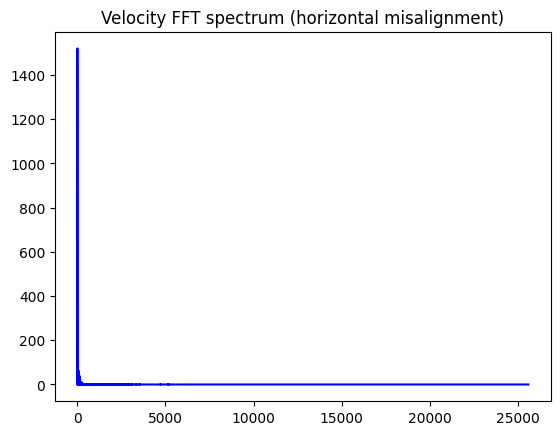

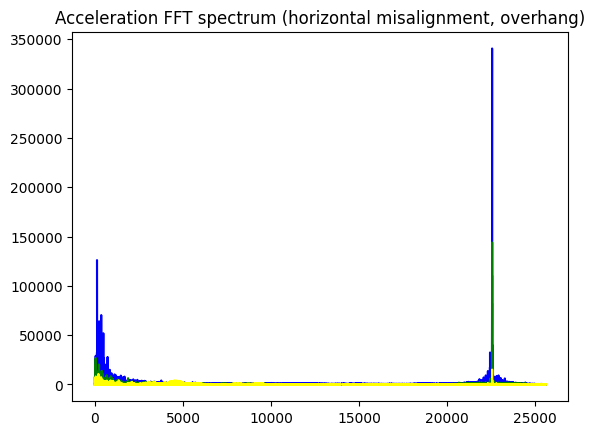

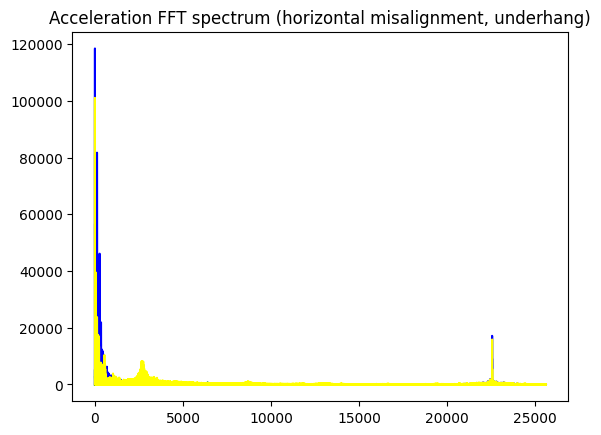

In [14]:
vel_fft_spectrum(df_hmis.iloc[:,0].values)
plt.title("Velocity FFT spectrum (horizontal misalignment)")
plt.show()

accel_fft_spectrum(df_hmis.iloc[:,1].values, df_hmis.iloc[:,2].values, df_hmis.iloc[:,3].values, df_hmis.iloc[:,1].shape[0])
plt.title("Acceleration FFT spectrum (horizontal misalignment, overhang)")
plt.show()

accel_fft_spectrum(df_hmis.iloc[:,4].values, df_hmis.iloc[:,5].values, df_hmis.iloc[:,6].values, df_hmis.iloc[:,4].shape[0])
plt.title("Acceleration FFT spectrum (horizontal misalignment, underhang)")
plt.show()

In [15]:
freq = df_hmis.iloc[:, 0].values
rad_per_sec = freq * (2 * (np.pi / 60))
ang_vel = cumtrapz(y=rad_per_sec, dx=1 / SAMPLE_RATE, initial=0)
ang_vel_fft = rfft(ang_vel - np.mean(ang_vel))

uhang_x = df_hmis.iloc[:, 1].values
uhang_y = df_hmis.iloc[:, 2].values
uhang_z = df_hmis.iloc[:, 3].values
uhang_x_fft = rfft(uhang_x - np.mean(uhang_x))
uhang_y_fft = rfft(uhang_y - np.mean(uhang_y))
uhang_z_fft = rfft(uhang_z - np.mean(uhang_z))

ohang_x = df_hmis.iloc[:, 4].values
ohang_y = df_hmis.iloc[:, 5].values
ohang_z = df_hmis.iloc[:, 6].values
ohang_x_fft = rfft(ohang_x - np.mean(ohang_x))
ohang_y_fft = rfft(ohang_y - np.mean(ohang_y))
ohang_z_fft = rfft(ohang_z - np.mean(ohang_z))

n_samples = df_hmis.shape[0]
df_fft_hmis = pd.DataFrame()

df_fft_hmis['ang_vel_fft'] = np.abs(ang_vel_fft[:n_samples])

df_fft_hmis['uhang_x_fft'] = np.abs(uhang_x_fft[:n_samples])
df_fft_hmis['uhang_y_fft'] = np.abs(uhang_y_fft[:n_samples])
df_fft_hmis['uhang_z_fft'] = np.abs(uhang_z_fft[:n_samples])

df_fft_hmis['ohang_x_fft'] = np.abs(ohang_x_fft[:n_samples])
df_fft_hmis['ohang_y_fft'] = np.abs(ohang_y_fft[:n_samples])
df_fft_hmis['ohang_z_fft'] = np.abs(ohang_z_fft[:n_samples])

df_fft_hmis['fftfreq'] = rfftfreq(n_samples, 1 / SAMPLE_RATE)
df_fft_hmis['class'] = 1
df_fft_hmis

,ang_vel_fft,uhang_x_fft,uhang_y_fft,uhang_z_fft,ohang_x_fft,ohang_y_fft,ohang_z_fft,fftfreq,class
0,3.014806e-13,3.772982e-12,1.517719e-11,1.189449e-11,1.917400e-11,5.556444e-12,5.942624e-11,0.000000,1
1,1.519762e+03,5.871617e+03,1.379373e+02,4.387922e+01,2.223351e+04,4.446791e+02,3.891103e+04,0.015515,1
2,1.020776e+03,7.883268e+03,2.483665e+01,1.089513e+02,4.162242e+03,4.183033e+01,3.083325e+04,0.031030,1
3,4.579864e+02,3.932776e+03,1.199423e+02,1.016256e+01,1.795033e+04,1.440472e+03,2.859370e+04,0.046545,1
4,5.907983e+02,5.359994e+03,1.124963e+02,1.717904e+02,2.986140e+04,6.763126e+02,5.625176e+04,0.062061,1
...,...,...,...,...,...,...,...,...,...
1649996,1.488919e-03,7.195937e+01,6.808718e+01,2.977233e+01,2.744682e+01,2.096013e+00,9.365936e+00,25599.937939,1
1649997,1.488919e-03,1.469895e+02,8.680593e+01,1.856237e+01,1.040303e+01,4.060893e-01,5.845390e+00,25599.953455,1
1649998,1.488919e-03,6.183783e+01,1.244989e+02,2.574548e+01,2.177429e+01,4.106327e+00,1.243454e+01,25599.968970,1
1649999,1.488919e-03,2.740034e+01,9.007329e+01,4.789731e+01,1.837800e+01,6.956911e+00,1.511481e+01,25599.984485,1


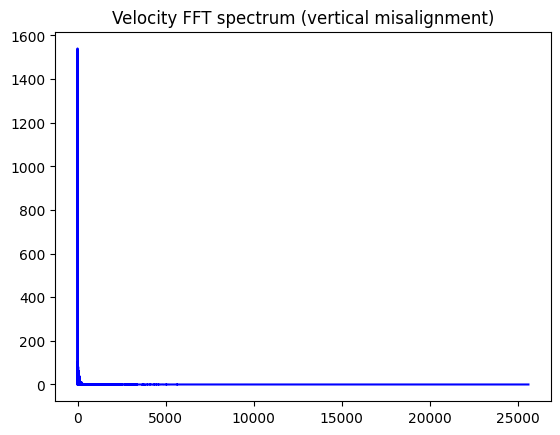

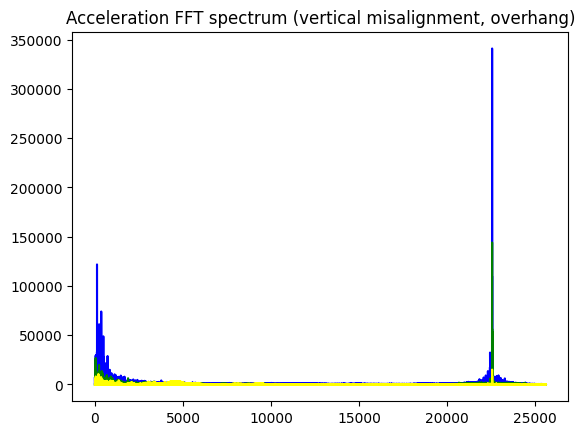

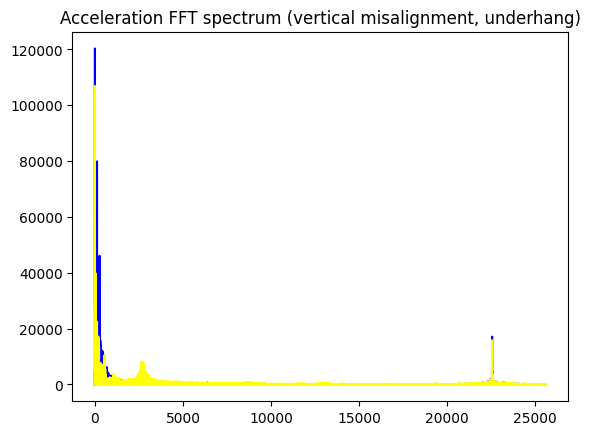

In [16]:
vel_fft_spectrum(df_vmis.iloc[:,0].values)
plt.title("Velocity FFT spectrum (vertical misalignment)")
plt.show()

accel_fft_spectrum(df_vmis.iloc[:,1].values, df_vmis.iloc[:,2].values, df_vmis.iloc[:,3].values, df_vmis.iloc[:,1].shape[0])
plt.title("Acceleration FFT spectrum (vertical misalignment, overhang)")
plt.show()

accel_fft_spectrum(df_vmis.iloc[:,4].values, df_vmis.iloc[:,5].values, df_vmis.iloc[:,6].values, df_vmis.iloc[:,4].shape[0])
plt.title("Acceleration FFT spectrum (vertical misalignment, underhang)")
plt.show()

In [17]:
freq = df_vmis.iloc[:, 0].values
rad_per_sec = freq * (2 * (np.pi / 60))
ang_vel = cumtrapz(y=rad_per_sec, dx=1 / SAMPLE_RATE, initial=0)
ang_vel_fft = rfft(ang_vel - np.mean(ang_vel))

uhang_x = df_vmis.iloc[:, 1].values
uhang_y = df_vmis.iloc[:, 2].values
uhang_z = df_vmis.iloc[:, 3].values
uhang_x_fft = rfft(uhang_x - np.mean(uhang_x))
uhang_y_fft = rfft(uhang_y - np.mean(uhang_y))
uhang_z_fft = rfft(uhang_z - np.mean(uhang_z))

ohang_x = df_vmis.iloc[:, 4].values
ohang_y = df_vmis.iloc[:, 5].values
ohang_z = df_vmis.iloc[:, 6].values
ohang_x_fft = rfft(ohang_x - np.mean(ohang_x))
ohang_y_fft = rfft(ohang_y - np.mean(ohang_y))
ohang_z_fft = rfft(ohang_z - np.mean(ohang_z))

n_samples = df_vmis.shape[0]
df_fft_vmis = pd.DataFrame()

df_fft_vmis['ang_vel_fft'] = np.abs(ang_vel_fft[:n_samples])

df_fft_vmis['uhang_x_fft'] = np.abs(uhang_x_fft[:n_samples])
df_fft_vmis['uhang_y_fft'] = np.abs(uhang_y_fft[:n_samples])
df_fft_vmis['uhang_z_fft'] = np.abs(uhang_z_fft[:n_samples])

df_fft_vmis['ohang_x_fft'] = np.abs(ohang_x_fft[:n_samples])
df_fft_vmis['ohang_y_fft'] = np.abs(ohang_y_fft[:n_samples])
df_fft_vmis['ohang_z_fft'] = np.abs(ohang_z_fft[:n_samples])

df_fft_vmis['fftfreq'] = rfftfreq(n_samples, 1 / SAMPLE_RATE)
df_fft_vmis['class'] = 2
df_fft_vmis

,ang_vel_fft,uhang_x_fft,uhang_y_fft,uhang_z_fft,ohang_x_fft,ohang_y_fft,ohang_z_fft,fftfreq,class
0,7.779461e-13,2.120260e-11,1.519140e-11,1.070255e-11,4.816414e-11,9.649170e-12,1.140421e-12,0.000000,2
1,1.540373e+03,4.829384e+03,1.314301e+02,4.878814e+01,1.590844e+04,4.627510e+02,3.335055e+04,0.015515,2
2,1.006129e+03,7.338648e+03,2.990680e+01,1.106324e+02,9.902949e+03,1.692066e+02,3.451638e+04,0.031030,2
3,4.685451e+02,2.971252e+03,1.170364e+02,8.685224e+00,1.071422e+04,1.315252e+03,2.327635e+04,0.046545,2
4,5.915870e+02,5.300694e+03,1.090727e+02,1.669703e+02,3.158582e+04,7.962343e+02,6.076822e+04,0.062061,2
...,...,...,...,...,...,...,...,...,...
1649996,1.445711e-03,6.716941e+01,6.534099e+01,2.741446e+01,3.050734e+01,2.772866e+00,1.270187e+01,25599.937939,2
1649997,1.445712e-03,1.479698e+02,8.511861e+01,2.068860e+01,6.936969e+00,1.128482e+00,3.118597e+00,25599.953455,2
1649998,1.445712e-03,6.461892e+01,1.190018e+02,2.341184e+01,1.878004e+01,3.353962e+00,8.072298e+00,25599.968970,2
1649999,1.445712e-03,2.385944e+01,8.589570e+01,5.017676e+01,1.572858e+01,6.297639e+00,1.200155e+01,25599.984485,2


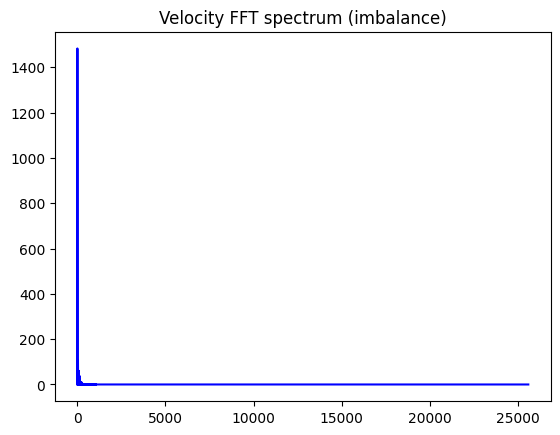

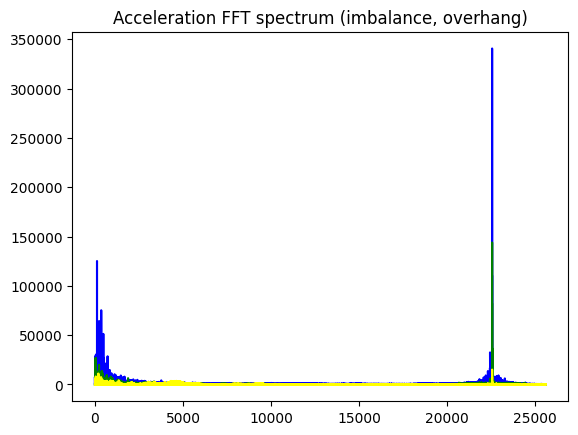

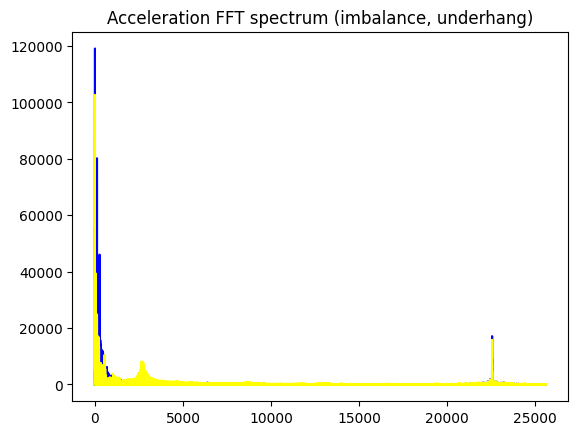

In [18]:
vel_fft_spectrum(df_imb.iloc[:,0].values)
plt.title("Velocity FFT spectrum (imbalance)")
plt.show()

accel_fft_spectrum(df_imb.iloc[:,1].values, df_imb.iloc[:,2].values, df_imb.iloc[:,3].values, df_imb.iloc[:,1].shape[0])
plt.title("Acceleration FFT spectrum (imbalance, overhang)")
plt.show()

accel_fft_spectrum(df_imb.iloc[:,4].values, df_imb.iloc[:,5].values, df_imb.iloc[:,6].values, df_imb.iloc[:,4].shape[0])
plt.title("Acceleration FFT spectrum (imbalance, underhang)")
plt.show()

In [19]:
freq = df_imb.iloc[:, 0].values
rad_per_sec = freq * (2 * (np.pi / 60))
ang_vel = cumtrapz(y=rad_per_sec, dx=1 / SAMPLE_RATE, initial=0)
ang_vel_fft = rfft(ang_vel - np.mean(ang_vel))

uhang_x = df_imb.iloc[:, 1].values
uhang_y = df_imb.iloc[:, 2].values
uhang_z = df_imb.iloc[:, 3].values
uhang_x_fft = rfft(uhang_x - np.mean(uhang_x))
uhang_y_fft = rfft(uhang_y - np.mean(uhang_y))
uhang_z_fft = rfft(uhang_z - np.mean(uhang_z))

ohang_x = df_imb.iloc[:, 4].values
ohang_y = df_imb.iloc[:, 5].values
ohang_z = df_imb.iloc[:, 6].values
ohang_x_fft = rfft(ohang_x - np.mean(ohang_x))
ohang_y_fft = rfft(ohang_y - np.mean(ohang_y))
ohang_z_fft = rfft(ohang_z - np.mean(ohang_z))

n_samples = df_imb.shape[0]
df_fft_imb = pd.DataFrame()

df_fft_imb['ang_vel_fft'] = np.abs(ang_vel_fft[:n_samples])

df_fft_imb['uhang_x_fft'] = np.abs(uhang_x_fft[:n_samples])
df_fft_imb['uhang_y_fft'] = np.abs(uhang_y_fft[:n_samples])
df_fft_imb['uhang_z_fft'] = np.abs(uhang_z_fft[:n_samples])

df_fft_imb['ohang_x_fft'] = np.abs(ohang_x_fft[:n_samples])
df_fft_imb['ohang_y_fft'] = np.abs(ohang_y_fft[:n_samples])
df_fft_imb['ohang_z_fft'] = np.abs(ohang_z_fft[:n_samples])

df_fft_imb['fftfreq'] = rfftfreq(n_samples, 1 / SAMPLE_RATE)
df_fft_imb['class'] = 3
df_fft_imb

,ang_vel_fft,uhang_x_fft,uhang_y_fft,uhang_z_fft,ohang_x_fft,ohang_y_fft,ohang_z_fft,fftfreq,class
0,4.238775e-13,3.677769e-11,1.132605e-11,2.746248e-12,3.217338e-11,4.831691e-12,4.861178e-11,0.000000,3
1,1.483143e+03,5.498226e+03,1.008532e+02,6.646619e+01,1.655398e+04,4.436355e+02,2.771089e+04,0.015515,3
2,1.048089e+03,7.668654e+03,5.835928e+01,1.117070e+02,9.070280e+03,3.659954e+01,3.898387e+04,0.031030,3
3,4.415219e+02,3.575038e+03,1.026002e+02,2.540575e+01,1.143641e+04,1.447036e+03,1.820606e+04,0.046545,3
4,5.922551e+02,5.327492e+03,1.007276e+02,1.466219e+02,3.107740e+04,6.687860e+02,6.536667e+04,0.062061,3
...,...,...,...,...,...,...,...,...,...
1649996,1.268511e-03,6.993380e+01,6.319890e+01,2.662967e+01,3.026657e+01,3.053023e+00,9.448216e+00,25599.937939,3
1649997,1.268511e-03,1.470079e+02,8.388541e+01,2.135249e+01,7.176853e+00,1.444944e+00,5.594827e+00,25599.953455,3
1649998,1.268511e-03,6.277992e+01,1.139975e+02,2.261021e+01,1.900336e+01,3.037295e+00,1.201068e+01,25599.968970,3
1649999,1.268511e-03,2.595382e+01,8.221225e+01,5.097142e+01,1.591777e+01,6.023374e+00,1.481397e+01,25599.984485,3


In [20]:
df_fft_general = pd.concat([df_fft_normal, df_fft_hmis, df_fft_vmis, df_fft_imb])
df_fft_general.reset_index(inplace=True, drop=True)
df_fft_general

,ang_vel_fft,uhang_x_fft,uhang_y_fft,uhang_z_fft,ohang_x_fft,ohang_y_fft,ohang_z_fft,fftfreq,class
0,4.377737e-13,2.840750e-11,1.899991e-11,1.740830e-13,1.378098e-11,2.202682e-12,6.818368e-11,0.000000,0
1,1.557003e+03,5.742650e+03,1.057515e+02,5.193293e+01,1.669130e+04,4.475786e+02,3.518353e+04,0.015754,0
2,9.691560e+02,7.845538e+03,5.159366e+01,1.092786e+02,8.729590e+03,6.034498e+01,3.320362e+04,0.031508,0
3,4.971058e+02,4.401388e+03,1.112835e+02,1.431125e+01,1.164635e+04,1.508573e+03,2.758101e+04,0.047262,0
4,5.702828e+02,5.235895e+03,9.353796e+01,1.683666e+02,3.142316e+04,5.364737e+02,5.687805e+04,0.063015,0
...,...,...,...,...,...,...,...,...,...
6574999,1.268511e-03,6.993380e+01,6.319890e+01,2.662967e+01,3.026657e+01,3.053023e+00,9.448216e+00,25599.937939,3
6575000,1.268511e-03,1.470079e+02,8.388541e+01,2.135249e+01,7.176853e+00,1.444944e+00,5.594827e+00,25599.953455,3
6575001,1.268511e-03,6.277992e+01,1.139975e+02,2.261021e+01,1.900336e+01,3.037295e+00,1.201068e+01,25599.968970,3
6575002,1.268511e-03,2.595382e+01,8.221225e+01,5.097142e+01,1.591777e+01,6.023374e+00,1.481397e+01,25599.984485,3


## Model training

### FFT data (classical algorithms)

### RAW data (CNNs)